# Métodos de ensamble en profundidad

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es familiarizarse con las técnicas de ensamble, identificar en qué se diferencian entre ellas y lograr comparar sus resultados.   </p>

# Etapas preliminares

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt # Para graficar
from sklearn.model_selection import train_test_split # Importa la función para dividir el conjunto de datos en train_test_split 
from sklearn import metrics #Importa metricas scikit-learn para el calculo del accuracy
from sklearn import preprocessing #Importa funciones para el procesamiento de los datos
from sklearn.metrics import confusion_matrix #Importa los métodos de cálculo de la matriz de confusión
from sklearn.metrics import precision_recall_fscore_support # Importa módulos para calcular métricas a partir de la matriz de confusión
from sklearn.preprocessing import MinMaxScaler # Importa métodos para normalizar usando minMax
from sklearn.preprocessing import StandardScaler # Importa métodos para normalizar usando ZScore
from sklearn.pipeline import make_pipeline # Importa métodos para hacer flujos sobre los datos
from sklearn.pipeline import Pipeline

<p><strong>Paso: Cargar los datos </strong></br>
A continuación cargaremos los datos que serán usados para entrenar y evaluar el modelo. La ruta de los datos puede variar. En caso en que tenga el archivo en el sistema de archivos de databricks (DBFS) podrá usar la opción 1. Si el archivo está en una dirección pública en internet podrá usar la opción 2. En la opción 1 deberá incluir la ruta en la que se encuentra el archivo en su sistema de archivos en DataBricks.

In [ ]:
path = "https://www.dropbox.com/s/kmsljv3eqfaf1tn/AdventureWorksPreparedRForest.csv?dl=1"

#Lectura del archivo csv
df1 = pd.read_csv(path, sep=";", encoding = "utf-8", decimal=',')


<p><strong>Paso: Explorar los datos </strong></br>
Este paso es fundamental para ver los atributos que tenemos disponibles y las características de cada uno de los atributos. Así mismo, se debe revisar el tamaño de los datos y el estado de calidad para identificar posibles acciones de preparación.

In [ ]:
print("Forma del conjunto de datos: \n", df1.shape)
print("La descripción: \n", df1.describe(include="all"))
print("Los tipos de datos: \n", df1.dtypes)
print("Los 5 primeros registros: \n", df1.head())
print("Los 5 últimos registros: \n", df1.tail())

Forma del conjunto de datos: 
 (18484, 16)
La descripción: 
           Unnamed: 0   EstadoCivil          Sexo IngresosAnuales TotalHijos  \
count   18484.000000  18484.000000  18484.000000           18484      18484   
unique           NaN           NaN           NaN              16          6   
top              NaN           NaN           NaN         60000.0        0.0   
freq             NaN           NaN           NaN            3127       5165   
mean     9241.500000      0.458396      0.505897             NaN        NaN   
std      5336.015523      0.498280      0.499979             NaN        NaN   
min         0.000000      0.000000      0.000000             NaN        NaN   
25%      4620.750000      0.000000      0.000000             NaN        NaN   
50%      9241.500000      0.000000      1.000000             NaN        NaN   
75%     13862.250000      1.000000      1.000000             NaN        NaN   
max     18483.000000      1.000000      1.000000             NaN      

In [ ]:
#Dividiremos el conjunto de datos en característicias (features) y la variable objetivo (target)
feature_cols = ['EstadoCivil', 'Sexo', 'IngresosAnuales', 'TotalHijos','Educacion','TieneCasa','NumeroCarros','Edad','DistanciaTrabajo', 'Ocu_Administrativo','Ocu_Gestión','Ocu_Obrero','Ocu_Obrero especializado','Ocu_Profesional']

#Datos para la creación del clasificador Random Forest
X = df1[feature_cols] # Features o Características que corresponde a las variables predictoras
y = df1.CompradorBicleta # Target o variable objetivo


In [ ]:
X

,EstadoCivil,Sexo,IngresosAnuales,TotalHijos,Educacion,TieneCasa,NumeroCarros,Edad,DistanciaTrabajo,Ocu_Administrativo,Ocu_Gestión,Ocu_Obrero,Ocu_Obrero especializado,Ocu_Profesional
0,0,1,90000.0,2.0,4,1.0,0.0,49.0,1,0,0,0,0,1
1,1,1,60000.0,3.0,4,0.0,1.0,49.0,0,0,0,0,0,1
2,0,1,60000.0,3.0,4,1.0,1.0,49.0,3,0,0,0,0,1
3,1,0,70000.0,0.0,4,0.0,1.0,47.0,4,0,0,0,0,1
4,1,0,80000.0,5.0,4,1.0,4.0,46.0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,0,1,30000.0,1.0,2,1.0,0.0,56.0,0,1,0,0,0,0
18480,1,0,30000.0,3.0,2,1.0,0.0,54.0,0,1,0,0,0,0
18481,1,1,30000.0,3.0,2,0.0,0.0,55.0,0,1,0,0,0,0
18482,0,1,30000.0,3.0,4,1.0,0.0,56.0,0,1,0,0,0,0


<p><strong>Paso: División del conjunto de datos en entrenamiento y pruebas </strong></br>
Para poder identificar la mejor parametrización de los algoritmos se usan diferentes estrategias. Una de ellas se llama Hold-Out y consiste en dejar un porcentaje para entrenar y otra para probar. Normalmente 70% para entrenar y 30% para probar.

In [ ]:
# Dividir el conjunto de datos conjunto de entrenamiento y en conjunto de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% entrenamiento y 30% prueba

In [ ]:
y_train

3692     0.0
13587    1.0
15012    1.0
9626     1.0
12333    0.0
        ... 
10955    1.0
17289    0.0
5192     0.0
12172    1.0
235      0.0
Name: CompradorBicleta, Length: 12938, dtype: object

In [ ]:
y_test

10499    0.0
13928    0.0
8291     0.0
13807    1.0
12558    0.0
        ... 
8067     1.0
16115    0.0
16015    0.0
1635     0.0
15546    1.0
Name: CompradorBicleta, Length: 5546, dtype: object

# Métodos de ensamble con modelos de una única técnica

## Random Forest
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test).
Selecciona una muestra del conjunto de atributos de entrada.

In [ ]:
from sklearn.ensemble import RandomForestClassifier # Importa el clasificador tipo ensamble llamado Random Forest

# Crear el clasificador
#clfRandomForest = RandomForestClassifier(n_estimators=200, n_jobs=2, random_state=0,  criterion="entropy", class_weight="balanced")
clfRandomForest = RandomForestClassifier(max_samples=10000, n_estimators=100, n_jobs=2, random_state=0,  criterion="gini", class_weight="balanced")


# Entrenar el Random Forest
clfRandomForest.fit(X_train, y_train)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predRandom = clfRandomForest.predict(X_test)
clfRandomForest.score(X_test, y_test)

0.7893977641543455

## Bagging
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test).
Selecciona una muestra del conjunto de entrenamiento (en su versión original) o también una muestra de los atributos de entrada (en python).

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Crear el clasificador
clfBagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=5), max_samples=0.9, max_features=0.9, random_state=0, n_estimators=100)
#Acá usamos KNN, pero puede ser otro modelo

# Entrenar el Bagging
clfBagging.fit(X_train, y_train)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predBagging = clfBagging.predict(X_test)
clfBagging.score(X_test, y_test)


0.7930039668229355

In [ ]:
# Podemos también aplicar el flujo de actividades sobre los datos y terminar ejecutando una técnica usando el objeto Pipeline. En este caso aplicamos primero normalización min-max y luego sí aplicamos el modelo KNN
pipe = Pipeline([('scaler', MinMaxScaler()), ('bag', BaggingClassifier(KNeighborsClassifier(n_neighbors=5, weights='distance'), max_samples=0.9, max_features=0.9, random_state=0, n_estimators=100))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7782185358817165

## ExtraTree
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test).

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Crear el clasificador
clfExtraTrees = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_split = 10, random_state=0)

# Entrenar el Extreme Trees
clfExtraTrees.fit(X_train, y_train)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predExtra = clfExtraTrees.predict(X_test)
clfExtraTrees.score(X_test, y_test)

0.796790479624955

## Ada Boost
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train), se usa primero todo el conjunto de entrenamiento con pesos normales, en la siguiente iteración se le da más peso a los que se clasificaron erróneamente en la iteración inicial.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Crear el clasificador
clfAdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=200, random_state=0)

# Entrenar el AdaBoost
clfAdaBoost.fit(X_train, y_train)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predAda = clfAdaBoost.predict(X_test)
clfAdaBoost.score(X_test, y_test)


0.785611251352326

## Gradient Boosting
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test).
Cada iteración busca optimizar la función de pérdida (loss function) seleccionando el árbol que más apunta  en la dirección del gradiente negativo, es decir el que más reduce el error (para clasificación, los registros mal clasificados).

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear el clasificador
clfGradientBoosting = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=0)

# Entrenar el Gradient Boosting
clfGradientBoosting.fit(X_train, y_train)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predGradient = clfGradientBoosting.predict(X_test)
clfGradientBoosting.score(X_test, y_test)


0.783086909484313

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = GradientBoostingClassifier(max_depth=5, random_state=0)
# Recorrido de parametros basado en Grid
n_estimators = [500, 600]
learning_rate = [0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# Resumen de resultados
print("Mejor score: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) con: %r" % (mean, stdev, param))
# Más información de las métricas para analizar cuál es el mejor modelo https://scikit-learn.org/stable/modules/model_evaluation.html

Mejor score: 0.803775 usando {'learning_rate': 0.1, 'n_estimators': 600}
0.744968 (0.009662) con: {'learning_rate': 0.01, 'n_estimators': 500}
0.750269 (0.009971) con: {'learning_rate': 0.01, 'n_estimators': 600}
0.803721 (0.010226) con: {'learning_rate': 0.1, 'n_estimators': 500}
0.803775 (0.011684) con: {'learning_rate': 0.1, 'n_estimators': 600}


# Métodos de ensamble que pueden integrar diferentes tipos de Modelos

## Voting
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test).
Permite integrar diferentes modelos usando una función ponderada de votación.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=5,random_state=0)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = SVC(kernel='rbf', probability=True, random_state=0)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
clfVoting = eclf.fit(X, y)

#Predecir la variable objetivo en los datos de prueba (probar el modelo)
y_predVoting = clfVoting.predict(X_test)
clfVoting.score(X_test, y_test)

0.786332491886044

# Ahora tú
Agrega otro clasificador y que tenga peso 1 en la votación.

In [ ]:
# Agrega aquí el código

## Stacking
Se entrenará el modelo con el conjunto de entrenamiento (X_train y Y_train) y luego haremos la predicción al conjunto de prueba (X_test). Permite apilar varios modelos de clasificación base y luego utiliza como función de combinación un modelo de clasificación que aprende de los errores de los clasificadores base.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

classifiers = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('svr', make_pipeline(StandardScaler(), LinearSVC(max_iter= 2000, random_state=0)))
 ]
clfStacking = StackingClassifier(
      estimators=classifiers, final_estimator=LogisticRegression()
)
clfStacking.fit(X_train, y_train)
clfStacking.score(X_test, y_test)

0.791020555355211

# Ahora tú
Grafica la curva ROC que compare al menos 3 de los métodos de ensamble

In [ ]:
# Agrega el código acá

## Importancia de atributos
Identificaremos la importancia que tuvieron los atributos en uno de los modelos que permite tener esta información (Random Forest)

In [ ]:
importances = clfRandomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clfRandomForest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Importancia de atributos:")

for f in range(X.shape[1]):
    print("%s: atributo %d (%f)" % (X.columns.values[indices[f]-1], indices[f], importances[indices[f]]))
  

Importancia de atributos:
NumeroCarros: atributo 7 (0.315425)
Sexo: atributo 2 (0.143031)
TieneCasa: atributo 6 (0.096987)
IngresosAnuales: atributo 3 (0.094754)
Edad: atributo 8 (0.092140)
TotalHijos: atributo 4 (0.062460)
Ocu_Profesional: atributo 0 (0.052413)
EstadoCivil: atributo 1 (0.050486)
Educacion: atributo 5 (0.042588)
Ocu_Obrero: atributo 12 (0.013307)
Ocu_Obrero especializado: atributo 13 (0.012988)
Ocu_Administrativo: atributo 10 (0.008797)
DistanciaTrabajo: atributo 9 (0.008642)
Ocu_Gestión: atributo 11 (0.005982)


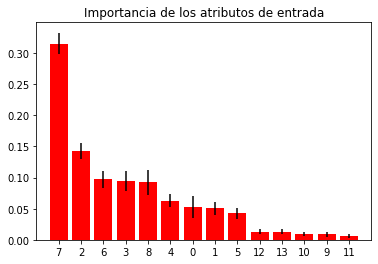

None

In [ ]:
# Graficar la importancia
plt.figure()
plt.title("Importancia de los atributos de entrada")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
image= plt.show()
display(image)